### Exploring dependency tree parsing using stanza and also CoreNLP

In [1]:
import os
import re
import unicodedata
import numpy as np
import pandas as pd
import warnings
import nltk
import spacy
import stanza
import en_core_web_md
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from collections import defaultdict
from textblob import TextBlob
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
word_token = TreebankWordTokenizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\peter\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load up the speeches

In [12]:
# Load up the files
#paths = ['./speeches/', './NYTimes/', './WSJ/'] 
paths = ['./GWB/']
list_of_files = []

dates = pd.read_csv('dateSpeeches.csv')
dates = pd.read_csv('speech_and_date_gwb.csv')
for path in paths:
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.txt'):
                list_of_files.append(os.path.join(root,file))

speeches = []
for file in list_of_files:
    with open(file, encoding='utf-8') as f:
        #print(file)
        text = f.read()
    f.close()
    speeches.append([text, file])

#clean out goofy unicode  space characters 
speeches = [(unicodedata.normalize("NFKD", speech[0]), speech[1]) for speech in speeches if len(speech)>0 ]

# remove [stuff] in between square brackets
def remove_bracket(text):
    return re.sub('(\[[^w]*\]\s)', '',text)
speeches = [(remove_bracket(speech[0]), speech[1]) for speech in speeches]

def get_source(text):
    regex = "[^./][a-zA-Z]+[^/]"
    string = re.findall(regex, str(text))[0]
    if string == 'speeches': string = 'oba'
    if string == 'NYTimes': string = 'nyt'
    return string.lower()

def get_date(text):
    regex = "([0-9]+[\-][0-9]+[\-][0-9]+)"
    return re.findall(regex, str(text))[0]

def get_filename(text):
    regex = "[-]([a-zA-Z]+)"
    return re.findall(regex, str(text))[0]

cols = ['text', 'filepath']
text_df = pd.DataFrame(speeches, columns=cols)
# A couple tweaks for the GWB data
dates['file'] = [ file.replace('GWB/', './GWB/') for file in dates['file'] ]
dates = dates.rename(columns={"file": "filepath"})
#text_df['date'] = text_df['filepath'].apply(get_date)
text_df = pd.merge(text_df, dates, how='left', on='filepath')
text_df['date'] = pd.to_datetime(text_df['date'], format='%Y-%m-%d')
text_df['source'] = text_df['filepath'].apply(get_source)

text_df['sentences'] = text_df['text'].apply(sent_tokenize)
text_df['words'] = text_df['text'].apply(word_token.tokenize)
text_df['num_sents'] = text_df['sentences'].apply(len)
text_df['num_words'] = text_df['words'].apply(len)
text_df['word_set'] = text_df['words'].apply(set)
text_df['num_unique_words'] = text_df['word_set'].apply(len)
text_df.head(3)

,text,filepath,date,source,sentences,words,num_sents,num_words,word_set,num_unique_words
0,To Chairman Dean and my great friend Dick Durb...,./GWB/address-accepting-the-presidential-nomin...,2008-06-03,gwb,[To Chairman Dean and my great friend Dick Dur...,"[To, Chairman, Dean, and, my, great, friend, D...",226,5080,"{land, hands., compassionate, rise, challengin...",1349
1,Thank you. Thank you all very much. Thank you....,./GWB/address-accepting-the-presidential-nomin...,2008-09-04,gwb,"[Thank you., Thank you all very much., Thank y...","[Thank, you., Thank, you, all, very, much., Th...",310,4802,"{land, rise, jobs, legislate, Thanks., constan...",1343
2,"Mr. Speaker, Vice President Cheney, Members of...",./GWB/address-before-joint-session-the-congres...,2006-01-31,gwb,"[Mr. Speaker, Vice President Cheney, Members o...","[Mr., Speaker, ,, Vice, President, Cheney, ,, ...",238,5395,"{hearts, Pflugerville, rise, minorities, compr...",1655


<A HREF="https://textblob.readthedocs.io/en/latest/quickstart.html">TextBlob Quickstart guide</A>

In [13]:
text_df['TBsubjectivity']=[TextBlob(text).sentiment.subjectivity for text in text_df['text']]
text_df['TBpolarity']=[TextBlob(text).sentiment.polarity for text in text_df['text']]
#text_df.to_csv('numwords_TBpolar_gwb.csv', index=False)

<A HREF="https://plotly.com/python/plotly-express/">Plotly Express</A><BR><A HREF="https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf">Pandas cheat sheet</A>

<A HREF="https://universaldependencies.org/u/pos/">Universal POS tags</A>

<A HREF="https://en.wikipedia.org/wiki/Interjection">Wikipedia - Interjections</A>

<A HREF="https://pypi.org/project/NRCLex/">NRCLex</A>

### Attempt 1. Stanza

### <A HREF="https://stanfordnlp.github.io/stanza/getting_started.html">Stanza quickstart guide</A>

In [14]:
nlp = stanza.Pipeline(lang="en") # Initialize the default English pipeline

2023-03-26 10:50:47 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-03-26 10:50:49 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2023-03-26 10:50:49 INFO: Use device: gpu
2023-03-26 10:50:49 INFO: Loading: tokenize
2023-03-26 10:50:51 INFO: Loading: pos
2023-03-26 10:50:51 INFO: Loading: lemma
2023-03-26 10:50:51 INFO: Loading: depparse
2023-03-26 10:50:52 INFO: Loading: sentiment
2023-03-26 10:50:52 INFO: Loading: constituency
2023-03-26 10:50:53 INFO: Loading: ner
2023-03-26 10:50:54 INFO: Done loading processors!


In [18]:
intxt=stanza.Document([], text=[sentence for sentence in text_df['sentences']][20][20])
out=nlp(intxt)
out

[
  [
    {
      "id": 1,
      "text": "Many",
      "lemma": "many",
      "upos": "ADJ",
      "xpos": "JJ",
      "feats": "Degree=Pos",
      "head": 2,
      "deprel": "amod",
      "start_char": 0,
      "end_char": 4,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 2,
      "text": "scientists",
      "lemma": "scientist",
      "upos": "NOUN",
      "xpos": "NNS",
      "feats": "Number=Plur",
      "head": 3,
      "deprel": "nsubj",
      "start_char": 5,
      "end_char": 15,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 3,
      "text": "believe",
      "lemma": "believe",
      "upos": "VERB",
      "xpos": "VBP",
      "feats": "Mood=Ind|Number=Plur|Person=3|Tense=Pres|VerbForm=Fin",
      "head": 0,
      "deprel": "root",
      "start_char": 16,
      "end_char": 23,
      "ner": "O",
      "multi_ner": [
        "O"
      ]
    },
    {
      "id": 4,
      "text": "that",
      "lemma": "that"

In [19]:
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in out.sentences for word in sent.words], sep='\n')

id: 1	word: Many	head id: 2	head: scientists	deprel: amod
id: 2	word: scientists	head id: 3	head: believe	deprel: nsubj
id: 3	word: believe	head id: 0	head: root	deprel: root
id: 4	word: that	head id: 11	head: lead	deprel: mark
id: 5	word: embryonic	head id: 8	head: research	deprel: amod
id: 6	word: stem	head id: 8	head: research	deprel: compound
id: 7	word: cell	head id: 8	head: research	deprel: compound
id: 8	word: research	head id: 11	head: lead	deprel: nsubj
id: 9	word: may	head id: 11	head: lead	deprel: aux
id: 10	word: eventually	head id: 11	head: lead	deprel: advmod
id: 11	word: lead	head id: 3	head: believe	deprel: ccomp
id: 12	word: to	head id: 13	head: therapies	deprel: case
id: 13	word: therapies	head id: 11	head: lead	deprel: obl
id: 14	word: that	head id: 17	head: used	deprel: nsubj:pass
id: 15	word: could	head id: 17	head: used	deprel: aux
id: 16	word: be	head id: 17	head: used	deprel: aux:pass
id: 17	word: used	head id: 13	head: therapies	deprel: acl:relcl
id: 18	word: t

### Attempt 2. Stanford's CoreNLP

In [20]:
# Using Stanford's CoreNLP parser with NLTK
# 1. Download CoreNLP from https://stanfordnlp.github.io/CoreNLP/download.html
# 2. make sure Java is installed, otherwise download and install Java - https://www.java.com/en/download/windows_manual.jsp
# 3. Unzip/extract CoreNLP zip file to a directory
# 4. Go to that directory and open a command terminal, and run the following command...
# 4b. on my laptop its in C:\Users\peter\stanford-corenlp-4.5.2
# 5. java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000
# 6. Now for graphviz if you want to view the parse trees, download from https://graphviz.org/download/ then install
# 7. Now, can run the following python code

In [21]:
# Can try this here, but may have to run from cmd terminal before continuing
!java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

Error: Could not find or load main class edu.stanford.nlp.pipeline.StanfordCoreNLPServer


In [22]:
from graphviz import Source
from nltk.parse.corenlp import CoreNLPDependencyParser
import os

In [23]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [25]:
sdp = CoreNLPDependencyParser()
sentence = [sentence for sentence in text_df['sentences']][20][20]
result = list(sdp.raw_parse(sentence))
dep_tree_dot_repr = [parse for parse in result][0].to_dot()
source = Source(dep_tree_dot_repr, filename="dep_tree", format='png')
source.view()
# Opens in pop-under window... well isn't that nice!

'dep_tree.png'

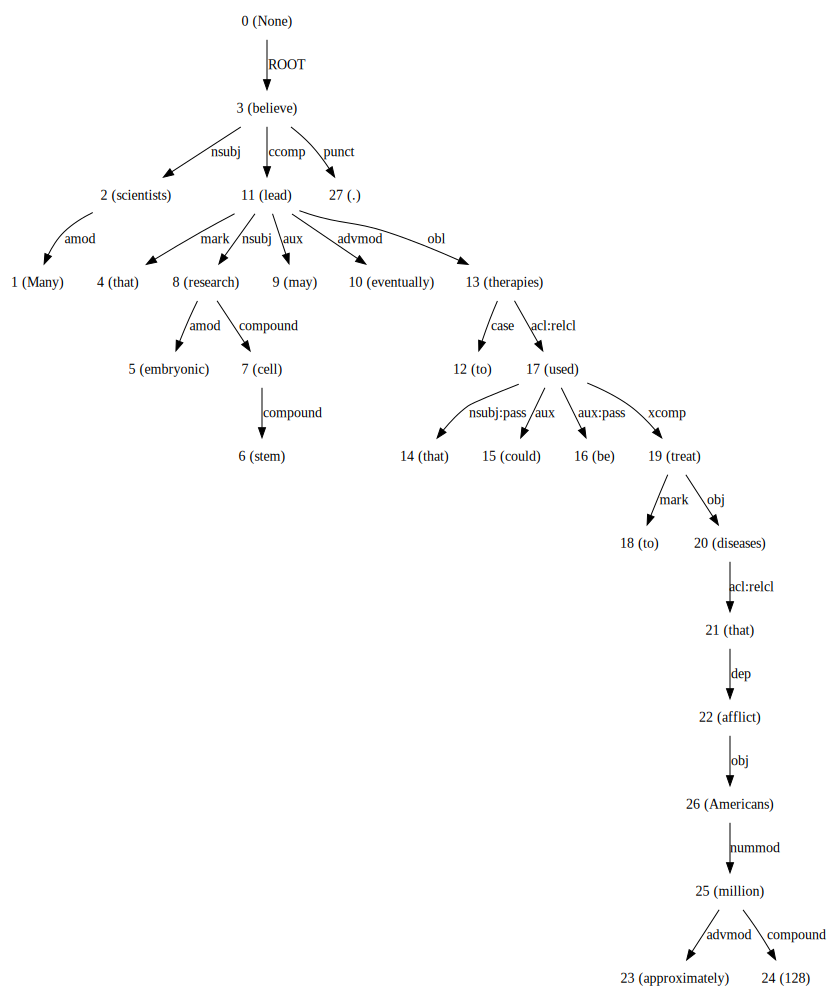

In [26]:
# Graph image doesn't get saved, need to re-run the code
source

### Attempt 3. Spacy

<A HREF="https://stackoverflow.com/questions/64591644/how-to-get-height-of-dependency-tree-with-spacy">Followed this code</A> couldn't have done it without this!

In [27]:
# Try this just to the the height of the parse tree... using spacy
nlp = spacy.load("en_core_web_md")
doc = nlp(sentence)
depths = {}
def walk_tree(node, depth):
    depths[node.orth_] = depth
    if node.n_lefts + node.n_rights > 0:
        return [walk_tree(child, depth+1) for child in node.children]
[walk_tree(sent.root, 0) for sent in doc.sents]
print(depths)
print(max(depths.values()))

{'believe': 0, 'scientists': 1, 'Many': 2, 'lead': 1, 'that': 8, 'research': 2, 'embryonic': 3, 'cell': 3, 'stem': 4, 'may': 2, 'eventually': 2, 'to': 6, 'therapies': 3, 'used': 4, 'could': 5, 'be': 5, 'treat': 5, 'diseases': 6, 'afflict': 7, 'Americans': 8, 'million': 9, 'approximately': 10, '128': 10, '.': 1}
10


In [28]:
def walk_tree_depth(node, depth):
    if node.n_lefts + node.n_rights > 0:
        return max(walk_tree_depth(child, depth+1) for child in node.children )
    else:
        return depth
    
print([walk_tree_depth(sent.root, 0) for sent in doc.sents])

[10]


In [29]:
[walk_tree_depth(sent.root, 0) for sent in doc.sents][0]

10

#### This makes the actual depth dataframe

In [30]:
# Make data frame of sentences and parse tree depth of each
def walk_tree_depth(node, depth):
    if node.n_lefts + node.n_rights > 0:
        return max(walk_tree_depth(child, depth+1) for child in node.children )
    else:
        return depth
    
tree_depth = pd.DataFrame(columns = ['date', 'source', 'sentence', 'depth'])
for i, speech in enumerate(text_df['sentences']):
    for j, sentence in enumerate(speech):
        doc = nlp(sentence)
        depth = [walk_tree_depth(sent.root, 0) for sent in doc.sents][0]
        tree_depth.loc[len(tree_depth)] = [text_df['date'].iloc[i], text_df['source'].iloc[i], sentence, depth]
        

In [31]:
tree_depth.head()

,date,source,sentence,depth
0,2008-06-03,gwb,To Chairman Dean and my great friend Dick Durb...,6
1,2008-06-03,gwb,Let me express my thanks to the historic slate...,9
2,2008-06-03,gwb,"To President Clinton, who last night made the ...",6
3,2008-06-03,gwb,I am grateful to finish this journey with one ...,9
4,2008-06-03,gwb,"To the love of my life, our next First Lady, M...",6


In [32]:
tree_depth.shape

(6840, 4)

In [33]:
#tree_depth.to_csv('sentence_depth_gwb.csv',index=False)

### Let's try spacy again for visualization

In [1]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("For everywhere in this country, there are first steps to be taken, there’s new ground to cover, there are more bridges to be crossed.")
# Since this is an interactive Jupyter environment, we can use displacy.render here
displacy.render(doc, style='dep')

2023-04-06 17:07:05.641944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 17:07:06.132692: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-06 17:07:07.014467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-06 17:07:07.014604: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
for token in doc:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
            [child for child in token.children])

For prep are VERB [everywhere]
everywhere pcomp For ADP [in]
in prep everywhere ADV [country]
this det country NOUN []
country pobj in ADP [this]
, punct are VERB []
there expl are VERB []
are ccomp ’s VERB [For, ,, there, steps]
first amod steps NOUN []
steps attr are VERB [first, taken]
to aux taken VERB []
be auxpass taken VERB []
taken relcl steps NOUN [to, be]
, punct ’s VERB []
there expl ’s VERB []
’s ccomp are VERB [are, ,, there, ground]
new amod ground NOUN []
ground attr ’s VERB [new, cover]
to aux cover VERB []
cover relcl ground NOUN [to]
, punct are VERB []
there expl are VERB []
are ROOT are VERB [’s, ,, there, bridges, .]
more amod bridges NOUN []
bridges attr are VERB [more, crossed]
to aux crossed VERB []
be auxpass crossed VERB []
crossed relcl bridges NOUN [to, be]
. punct are VERB []


In [3]:
for chunk in doc.noun_chunks:
    print(chunk.text, chunk.root.text, chunk.root.dep_,
            chunk.root.head.text)

this country country pobj in
first steps steps attr are
new ground ground attr ’s
more bridges bridges attr are


In [5]:
# Finding a verb with a subject from below — good
from spacy.symbols import nsubj, VERB
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

set()


In [6]:
print([token.text for token in doc[2].lefts])  # ['bright', 'red']
print([token.text for token in doc[2].rights])  # ['on']
print(doc[2].n_lefts)  # 2
print(doc[2].n_rights)  # 1

[]
['country']
0
1


In [7]:
root = [token for token in doc if token.head == token][0]
subject = list(root.lefts)[0]
for descendant in subject.subtree:
    assert subject is descendant or subject.is_ancestor(descendant)
    print(descendant.text, descendant.dep_, descendant.n_lefts,
            descendant.n_rights,
            [ancestor.text for ancestor in descendant.ancestors])

For prep 0 1 ['are', '’s', 'are']
everywhere pcomp 0 1 ['For', 'are', '’s', 'are']
in prep 0 1 ['everywhere', 'For', 'are', '’s', 'are']
this det 0 0 ['country', 'in', 'everywhere', 'For', 'are', '’s', 'are']
country pobj 1 0 ['in', 'everywhere', 'For', 'are', '’s', 'are']
, punct 0 0 ['are', '’s', 'are']
there expl 0 0 ['are', '’s', 'are']
are ccomp 3 1 ['’s', 'are']
first amod 0 0 ['steps', 'are', '’s', 'are']
steps attr 1 1 ['are', '’s', 'are']
to aux 0 0 ['taken', 'steps', 'are', '’s', 'are']
be auxpass 0 0 ['taken', 'steps', 'are', '’s', 'are']
taken relcl 2 0 ['steps', 'are', '’s', 'are']
, punct 0 0 ['’s', 'are']
there expl 0 0 ['’s', 'are']
’s ccomp 3 1 ['are']
new amod 0 0 ['ground', '’s', 'are']
ground attr 1 1 ['’s', 'are']
to aux 0 0 ['cover', 'ground', '’s', 'are']
cover relcl 1 0 ['ground', '’s', 'are']


In [13]:
displacy.serve(doc, style="dep")


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.
